### Limpieza de datos

In [2]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import plotly.graph_objects as go
from gtda.plotting import plot_point_cloud
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


### Verificaciones

In [3]:
import pandas as pd
# Lee el archivo CSV especificando el delimitador y la columna de fechas
df = pd.read_csv('archivo_dividido.csv', delimiter=',', parse_dates=['Date'])

# Verifica que cada año avance coherentemente
def verificar_orden(dataframe):
    years = dataframe['Date'].dt.year.tolist()
    sorted_years = sorted(years)
    if years == sorted_years:
        print("Los años avanzan coherentemente en orden ascendente.")
    else:
        print("¡Error! Los años no avanzan coherentemente.")

verificar_orden(df)
df.head()

Los años avanzan coherentemente en orden ascendente.


,Date,January,February,March,April,May,June,July,August,September,October,November,December
0,1870-01-01,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871-01-01,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872-01-01,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873-01-01,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874-01-01,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14


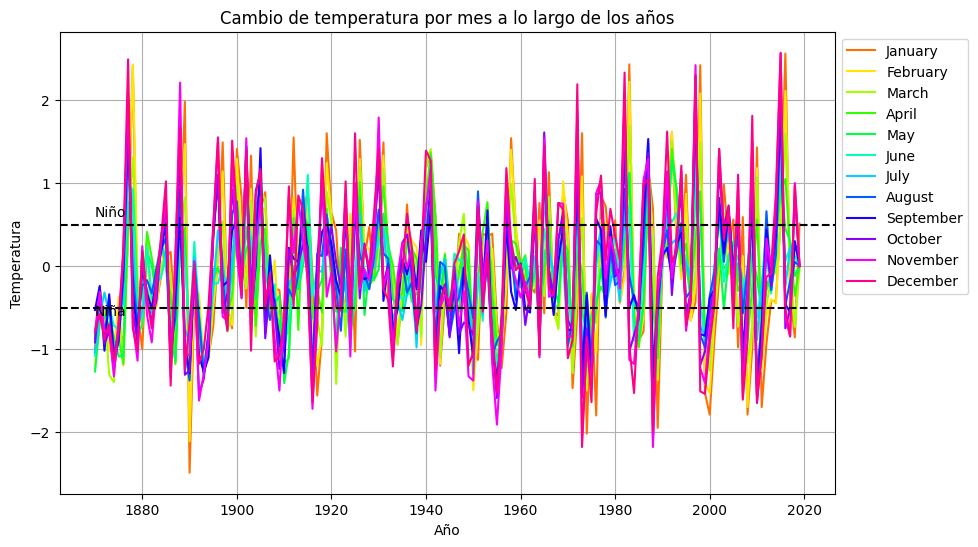

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya has leído y procesado los datos del archivo CSV como lo has hecho en tu código

# Crear una gráfica para mostrar el cambio de temperatura para cada mes a lo largo de todos los años
plt.figure(figsize=(10, 6))

# Conjunto para almacenar etiquetas únicas
used_labels = set()

# Definir una paleta de colores categóricos
palette = sns.color_palette("hsv", len(df.columns[1:]))

# Iterar sobre los meses y las columnas de temperatura
for month in range(1, 13):
    # Filtrar los datos para el mes actual
    month_data = df[df['Date'].dt.month == month]
    # Obtener la cantidad de datos para este mes
    num_data_points = month_data.shape[0]
    # Iterar sobre las columnas de temperatura y graficarlas si hay datos suficientes
    for i, col in enumerate(df.columns[1:]):
        # Verificar si la etiqueta ya se ha usado y si hay suficientes datos para graficar
        if col not in used_labels and num_data_points > 0:
            plt.plot(month_data['Date'], month_data[col], label=col, color=palette[i])
            used_labels.add(col)  # Agregar la etiqueta al conjunto de etiquetas usadas
    
# Configurar etiquetas y título
plt.xlabel('Año')
plt.ylabel('Temperatura')
plt.title('Cambio de temperatura por mes a lo largo de los años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Agregar líneas horizontales para los umbrales y etiquetar las regiones
plt.axhline(y=-0.5, color='black', linestyle='--', label='Umbral -0.5 (Niña)')
plt.axhline(y=0.5, color='black', linestyle='--', label='Umbral 0.5 (Niño)')

# Agregar texto para etiquetar las regiones
plt.text(df['Date'].iloc[0], -0.6, 'Niña', fontsize=10, color='black')
plt.text(df['Date'].iloc[0], 0.6, 'Niño', fontsize=10, color='black')

plt.show()

In [7]:

# Extrae la variación de temperatura y el tiempo
temperatura = df.iloc[:, 1:].values.flatten()
tiempo = df["Date"].dt.year

# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=tiempo, 
    y=temperatura, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Variación de temperatura a lo largo del tiempo',
    xaxis=dict(title='Año'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()


In [ ]:
def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

In [ ]:
max_periodic_dimension=70
max_periodic_time_delay=70
stride=1
tau,d= takens_embedding_optimal_parameters(temperatura, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)


Optimal time delay:  17 
Optimal dimension:  7


El primer mínimo local ocurre en:


9

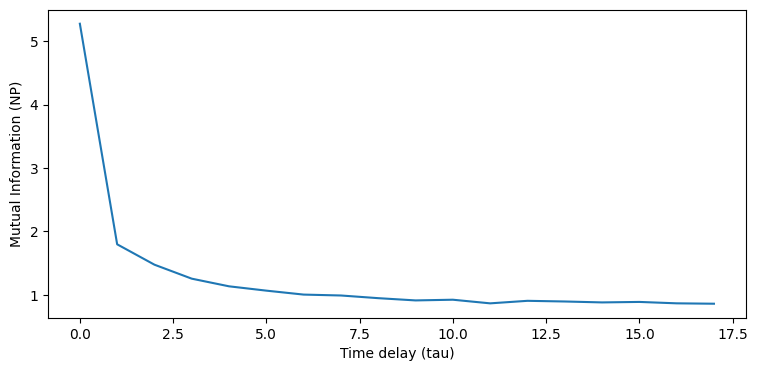

In [ ]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information (NP)')
plt.plot(delay.dmi(temperatura, maxtau=18))
print('El primer mínimo local ocurre en:')
find_optimal_delay(temperatura, maxtau=18)


La dimensión óptima con tau=26 es:  3


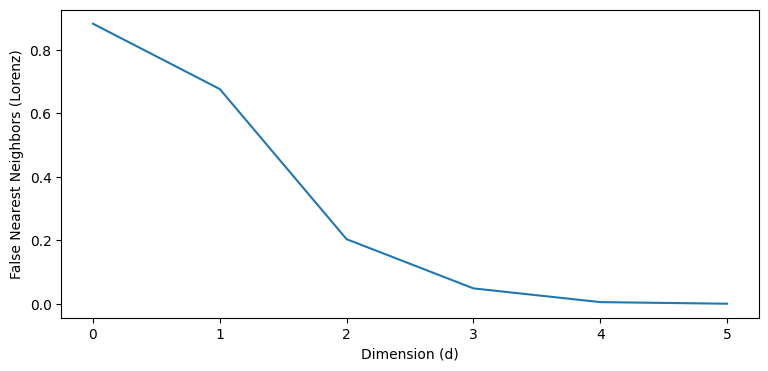

In [ ]:
test_dim = np.arange(1, 7)
f1, f2, f3 = dimension.fnn(x=np.array(temperatura.tolist()),
                           dim=test_dim,
                           tau=5,
                           metric='euclidean')

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (Lorenz)')
plt.plot(f1)
print("La dimensión óptima con tau=26 es: ", [f<=0.1 for f in f1].index(True))

In [ ]:
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=17,
    dimension=7,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(temperatura)


y_periodic_embedded = embedder_periodic.fit_transform(temperatura)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

Shape of embedded time series: (1698, 7)


In [ ]:
pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

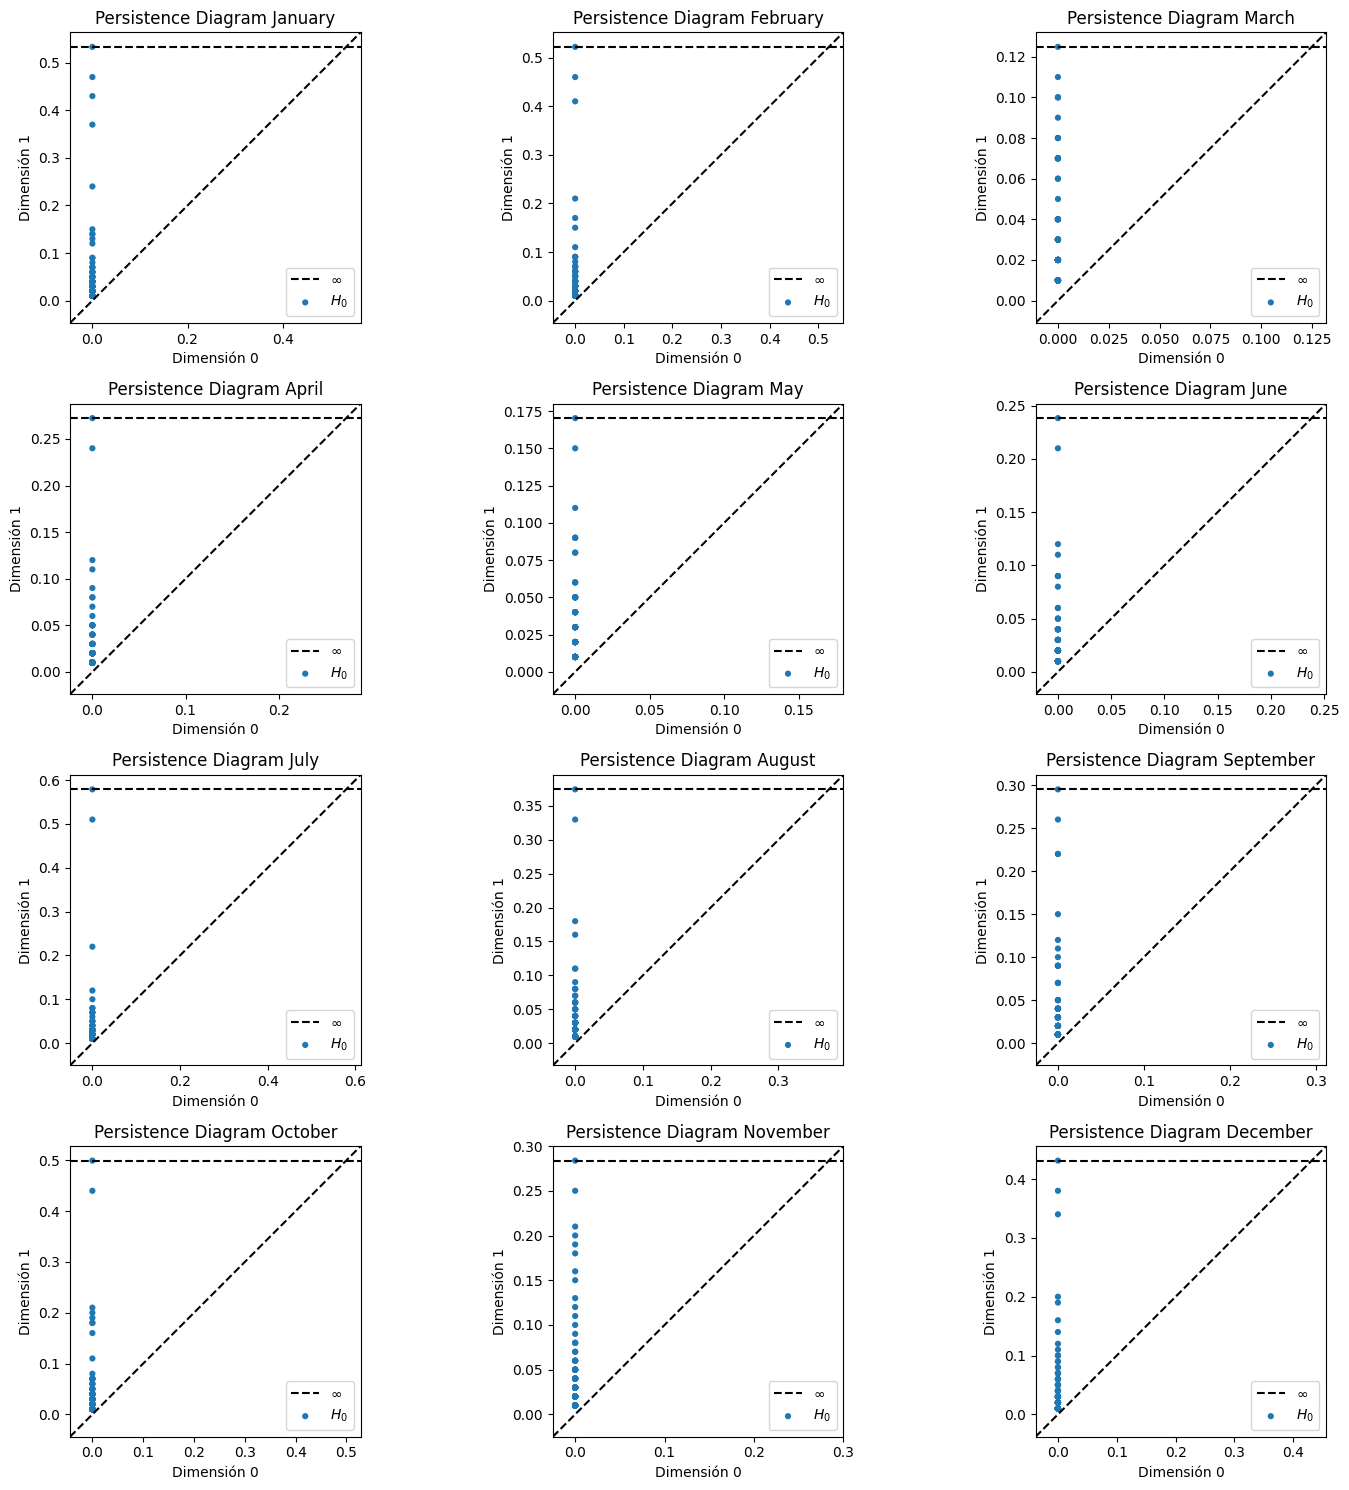

<function persistence_model at 0x00000120D8F5C790>


In [ ]:
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
def persistence_model(data, month_name, ax):
    """
    data: Conjunto de datos
    month_name: Nombre del mes
    ax: Eje para agregar el diagrama de persistencia
    """
    # Convertir el conjunto de datos en un array de numpy
    data_array = np.array(data).reshape(-1, 1)
    
    # Calcular el diagrama de persistencia con Ripser
    diagram = ripser(data_array)['dgms'][0]
    
    # Visualizar el diagrama de persistencia con Persim
    plot_diagrams(diagram, ax=ax)
    
    # Añadir título y etiqueta para el mes
    ax.set_title(f'Persistence Diagram {month_name}')
    ax.set_xlabel('Dimensión 0')
    ax.set_ylabel('Dimensión 1')

# Obtener la serie de tiempo de todos los meses
datos = df

# Crear subplots para cada columna de datos
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

# Calcular la persistencia y visualizar en subplots para cada columna de datos
for i, column in enumerate(datos.columns[1:]):
    row = i // 3
    col = i % 3
    persistence_model(datos[column], column, ax=axes[row, col])

# Ajustar el diseño y mostrar los subplots
plt.tight_layout()
plt.show()
print(persistence_model)